# Number of users and tweets 
Overall and by period (month, quarter)

In [12]:
# Takes ~16 min
import os
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

dirpath = '../output/tweets_bios_identities/'
tweet_fpaths = sorted(glob(os.path.join(dirpath, '*')))

def select_from_dump(tweet_fpath):
    tweets = pd.read_json(tweet_fpath, lines=True)
    return tweets.drop_duplicates(subset=['id_str'])[['id_str', 'user.id_str', 'created_at']]

dfs = process_map(select_from_dump, tweet_fpaths, max_workers=25, total=len(tweet_fpaths))
len(dfs)

  0%|          | 0/785 [00:00<?, ?it/s]

785

In [13]:
tweets = pd.concat(dfs)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485053009 entries, 0 to 1039509
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id_str       int64         
 1   user.id_str  int64         
 2   created_at   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 14.5 GB


In [14]:
# Save out for stats
tweets.to_pickle('../tmp/user_tweet_ids_overtime.pkl')

In [15]:
len(tweets['user.id_str'].unique())

17221733

In [16]:
import datetime

tweets2020 = tweets[tweets.created_at < datetime.datetime(2021,1,1)]
tweets2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349084005 entries, 0 to 1039509
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id_str       int64         
 1   user.id_str  int64         
 2   created_at   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.4 GB


In [17]:
len(tweets2020['user.id_str'].unique())

13663557

In [7]:
# Get stats
monthly = tweets.groupby(pd.Grouper(key='created_at', freq='MS')).agg(
    n_tweets=pd.NamedAgg(column="id_str", aggfunc="count"), 
    n_unique_users=pd.NamedAgg(column="user.id_str", aggfunc=lambda x: len(set(x))))
monthly.info()
monthly.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2020-01-01 to 2022-06-01
Freq: MS
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   n_tweets        30 non-null     int64
 1   n_unique_users  30 non-null     int64
dtypes: int64(2)
memory usage: 720.0 bytes


,n_tweets,n_unique_users
created_at,,
2020-01-01,1710781,706925
2020-02-01,13637918,2115615
2020-03-01,41149267,5344798
2020-04-01,42409718,4831125
2020-05-01,42146216,4691446


In [9]:
monthly.to_csv('../output/analysis/monthly_stats.csv')

In [6]:
import pandas as pd
monthly = pd.read_csv('../output/analysis/monthly_stats.csv').set_index('created_at')
monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 2020-01-01 to 2022-06-01
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   n_tweets        30 non-null     int64
 1   n_unique_users  30 non-null     int64
dtypes: int64(2)
memory usage: 720.0+ bytes


In [12]:
# Get stats
quarterly = tweets.groupby(pd.Grouper(key='created_at', freq='3MS')).agg(
    n_tweets=pd.NamedAgg(column="id_str", aggfunc="count"), 
    n_unique_users=pd.NamedAgg(column="user.id_str", aggfunc=lambda x: len(set(x))))
quarterly.info()
quarterly

IOStream.flush timed out
IOStream.flush timed out


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2020-01-01 to 2022-04-01
Freq: 3MS
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   n_tweets        10 non-null     int64
 1   n_unique_users  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes


,n_tweets,n_unique_users
created_at,,
2020-01-01,56497966,5953396
2020-04-01,140075485,8160078
2020-07-01,91317103,6700355
2020-10-01,61193451,5436098
2021-01-01,27083900,3650526
2021-04-01,37019512,3892513
2021-07-01,32919417,3362945
2021-10-01,22371415,2643020
2022-01-01,13903560,2180296


In [13]:
quarterly.to_csv('../output/analysis/quarterly_stats.csv')

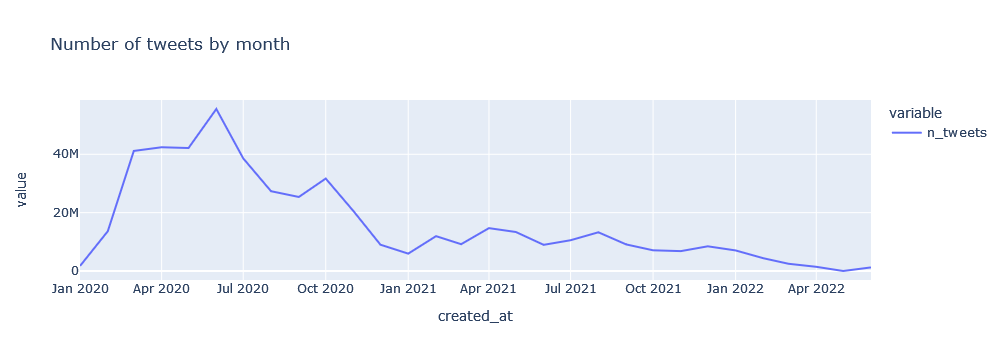

In [9]:
pd.options.plotting.backend = 'plotly'
monthly['n_tweets'].plot.line(title='Number of tweets by month')

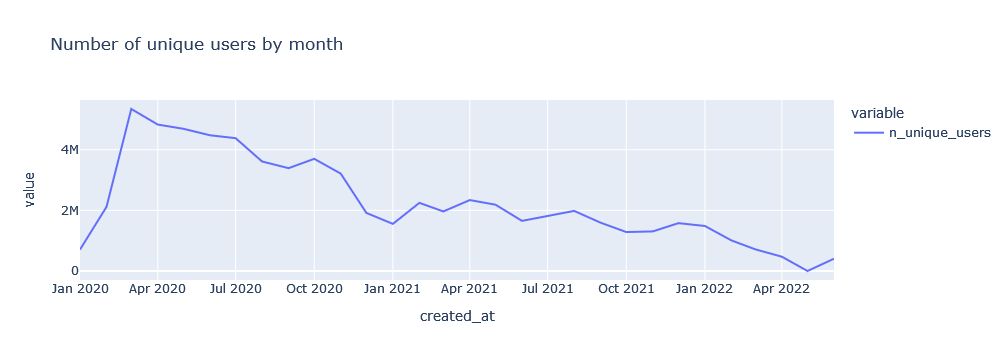

In [10]:
monthly['n_unique_users'].plot.line(title='Number of unique users by month')

In [6]:
tweets.created_at.dt.date.unique()[0].strftime("%Y-%m-%d")

'2020-06-02'

In [7]:
# Number of tweets
len(tweets['id_str'].unique())

924634
924189


In [ ]:
len(tweets['user.id_str'].unique()